# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, f1_score, accuracy_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

import joblib
import zipfile
#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int32  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int32  
 6   int             447136 non-null  int32  
 7   atm             447136 non-null  int32  
 8   col             447136 non-null  int32  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int32  
 12  circ            447136 non-null  int32  
 13  prof            447136 non-null  int32  
 14  plan            447136 non-null  int32  
 15  surf            447136 non-null  int32  
 16  infra           447136 non-null  int32  
 17  situ           

# Regroupement de modalités de 'grav' en 2 modalités : "blessés légers" et "autres" 

In [5]:
# "indemnes (1) + tués (2) + blessés hospitalisés (3)" => 0
df['grav'] = df['grav'].replace([1, 2, 3], 0)

# "bléssés légers (4)" => 1
df['grav'] = df['grav'].replace([4], 1)

df['grav'].unique()

array([1, 0])

# Séparation en train et test

Suppression des colonnes qui ne serviront pas pour la modélisation

In [6]:
df = df.drop(['an', 'jour', 'grav_rec', 'date', 'dep'], axis = 1)

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.59657
1    0.40343
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.59657
1    0.40343
Name: proportion, dtype: float64
grav
0    0.59657
1    0.40343
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

# Création de train et test avec Oversampling et Undersampling

### Oversampling

Avec SMOTE

In [10]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
smo = SMOTENC(categorical_features = cat)
X_train_sm, y_train_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

Classes échantillon SMOTE : {1: 200061, 0: 200061}


Avec RandomOverSampler

In [11]:
rOs = RandomOverSampler()
X_train_ro, y_train_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

Classes échantillon oversampled : {1: 200061, 0: 200061}


### Undersampling

Avec RandomUnderSampler

In [12]:
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 135291, 1: 135291}


Avec ClusterCentroids

In [13]:
cc = ClusterCentroids()
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_train_cc).value_counts()))

Classes échantillon CC : {0: 135291, 1: 135291}


# Decision Tree

### Selection des variables

In [48]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

In [49]:
print("Train acuracy :", np.round(dt.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.92 %
Test acuracy :  64.35 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,46395,20292
1,19560,25537



Rapport de classification :
               precision    recall  f1-score   support

           0       0.70      0.70      0.70     66687
           1       0.56      0.57      0.56     45097

    accuracy                           0.64    111784
   macro avg       0.63      0.63      0.63    111784
weighted avg       0.64      0.64      0.64    111784



Calcul de l'importance de chaque variable

In [50]:
importances_dt = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dt.feature_importances_,3)})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(38)

,importance
feature,
lat,0.153
long,0.141
age_usager,0.123
heure,0.072
mois,0.058
eq_ceinture,0.048
place_rec,0.040
col,0.037
agg,0.026


In [51]:
importances_dt.shape

(35, 1)

Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [52]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_dt), 1):
    liste_var = importances_dt.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    dt_2 = DecisionTreeClassifier(random_state = 42).fit(X_train_2, y_train)

    score = dt_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_dt = pd.DataFrame(dico)
y_pred_tableau_dt = y_pred_tableau_dt.sort_values(by = 'scores', ascending = False)
y_pred_tableau_dt.head(5)

,nombre_variable,scores
26,27,0.645969
24,25,0.645271
27,28,0.645155
29,30,0.644940
28,29,0.644904


In [53]:
nb_variable_dt = y_pred_tableau_dt.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_dt, 'variables')

La meilleur accuracy est obtenue avec 27.0 variables


In [54]:
meilleurs_variables_dt = importances_dt.index[0 : int(nb_variable_dt)]
meilleurs_variables_dt

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine'],
      dtype='object', name='feature')

In [55]:
liste_var = importances_dt.index[0 : int(nb_variable_dt)]
X_train_dt = X_train[liste_var]
X_test_dt = X_test[liste_var]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

In [56]:
print("Train acuracy :", np.round(dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.92 %
Test acuracy :  64.6 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,46736,19951
1,19624,25473



Rapport de classification :
               precision    recall  f1-score   support

           0       0.70      0.70      0.70     66687
           1       0.56      0.56      0.56     45097

    accuracy                           0.65    111784
   macro avg       0.63      0.63      0.63    111784
weighted avg       0.65      0.65      0.65    111784



### Hyperparamétrage

In [14]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine']
X_train_dt = X_train[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

##### Avec class_weight = None

In [58]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [59]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.693990
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.680613
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.693945
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.677259
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.695111
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.694962
140  {'class_weight': None, 'criterion': 'entropy',...         0.694139
141  {'class_weight': None, 'criterion': 'entropy',...         0.694962
142  {'class_weight': None, 'criterion': 'entropy',...         0.694139
143  {'class_weight': None, 'criterion': 'entropy',...         0.694962

[144 rows x 2 columns]


In [60]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6966769230616017


In [61]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 72.91 %
Test acuracy :  70.18 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54343,12344
1,20993,24104



Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.81      0.77     66687
           1       0.66      0.53      0.59     45097

    accuracy                           0.70    111784
   macro avg       0.69      0.67      0.68    111784
weighted avg       0.70      0.70      0.70    111784



Recherche du meilleur max_depth

In [29]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [30]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.673480670756975


In [31]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 72.64 %
Test acuracy :  69.86 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54566,12121
1,21572,23525



Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.82      0.76     66687
           1       0.66      0.52      0.58     45097

    accuracy                           0.70    111784
   macro avg       0.69      0.67      0.67    111784
weighted avg       0.69      0.70      0.69    111784



##### Avec class_weight = 'balanced'

In [62]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

In [63]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': 'balanced', 'criterion': 'gin...         0.678609
1    {'class_weight': 'balanced', 'criterion': 'gin...         0.664582
2    {'class_weight': 'balanced', 'criterion': 'gin...         0.676570
3    {'class_weight': 'balanced', 'criterion': 'gin...         0.673114
4    {'class_weight': 'balanced', 'criterion': 'gin...         0.682092
..                                                 ...              ...
139  {'class_weight': 'balanced', 'criterion': 'ent...         0.679543
140  {'class_weight': 'balanced', 'criterion': 'ent...         0.677121
141  {'class_weight': 'balanced', 'criterion': 'ent...         0.679543
142  {'class_weight': 'balanced', 'criterion': 'ent...         0.677121
143  {'class_weight': 'balanced', 'criterion': 'ent...         0.679543

[144 rows x 2 columns]


In [64]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
0.6820922438791761


In [65]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 69.16 %
Test acuracy :  68.59 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,48622,18065
1,17050,28047



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.73      0.73     66687
           1       0.61      0.62      0.62     45097

    accuracy                           0.69    111784
   macro avg       0.67      0.68      0.67    111784
weighted avg       0.69      0.69      0.69    111784



Sélection du meilleur max_depth

In [32]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [2, 4, 6, 8, 10, 12],
            'min_samples_split' : [20], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [33]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
0.6739594742949444


In [34]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 70.02 %
Test acuracy :  68.62 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,48227,18460
1,16619,28478



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.72      0.73     66687
           1       0.61      0.63      0.62     45097

    accuracy                           0.69    111784
   macro avg       0.68      0.68      0.68    111784
weighted avg       0.69      0.69      0.69    111784



##### Recherche du meilleur class_weight

In [15]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30],
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:3, 1:4}]
            }

In [16]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'class_weight': {0: 3, 1: 4}, 'criterion': 'g...         0.699546
1   {'class_weight': {0: 3, 1: 4}, 'criterion': 'g...         0.699495
2   {'class_weight': {0: 3, 1: 4}, 'criterion': 'g...         0.699546
3   {'class_weight': {0: 3, 1: 4}, 'criterion': 'g...         0.699331
4   {'class_weight': {0: 3, 1: 4}, 'criterion': 'g...         0.699331
..                                                ...              ...
67  {'class_weight': {0: 3, 1: 4}, 'criterion': 'e...         0.675335
68  {'class_weight': {0: 3, 1: 4}, 'criterion': 'e...         0.675335
69  {'class_weight': {0: 3, 1: 4}, 'criterion': 'e...         0.683127
70  {'class_weight': {0: 3, 1: 4}, 'criterion': 'e...         0.683127
71  {'class_weight': {0: 3, 1: 4}, 'criterion': 'e...         0.683127

[72 rows x 2 columns]


In [17]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
0.6995455520668813


In [18]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 71.09 %
Test acuracy :  70.18 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49121,17566
1,15770,29327



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     66687
           1       0.63      0.65      0.64     45097

    accuracy                           0.70    111784
   macro avg       0.69      0.69      0.69    111784
weighted avg       0.70      0.70      0.70    111784



Sélection du meilleur max_depth

In [54]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [2, 4, 6, 8, 10, 12],
            'min_samples_split' : [20], 
            'min_samples_leaf' : [1],
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:3, 1:4}]
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [55]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
0.6892186150414309


In [56]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 71.09 %
Test acuracy :  70.18 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49121,17566
1,15770,29327



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.74      0.75     66687
           1       0.63      0.65      0.64     45097

    accuracy                           0.70    111784
   macro avg       0.69      0.69      0.69    111784
weighted avg       0.70      0.70      0.70    111784



##### Avec SMOTE

In [38]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine']
X_train_sm_dt = X_train_sm[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_sm_dt, y_train_sm)

In [71]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [72]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_sm_dt, y_train_sm)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.670028
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.653698
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.672750
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.657495
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.670471
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.680038
140  {'class_weight': None, 'criterion': 'entropy',...         0.682030
141  {'class_weight': None, 'criterion': 'entropy',...         0.680038
142  {'class_weight': None, 'criterion': 'entropy',...         0.682030
143  {'class_weight': None, 'criterion': 'entropy',...         0.680038

[144 rows x 2 columns]


In [73]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6822644491251187


In [74]:
print("Train acuracy :", np.round(grid_dt.score(X_train_sm_dt, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 72.15 %
Test acuracy :  68.6 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,47345,19342
1,15756,29341



Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.71      0.73     66687
           1       0.60      0.65      0.63     45097

    accuracy                           0.69    111784
   macro avg       0.68      0.68      0.68    111784
weighted avg       0.69      0.69      0.69    111784



Sélection du meilleur max_depth

In [39]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_sm_dt, y_train_sm)

In [40]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6829015014639663


In [41]:
y_train_pred = grid_dt_2.predict(X_train_sm_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 70.97 %
Test acuracy :  68.28 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,47728,18959
1,16494,28603



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.72      0.73     66687
           1       0.60      0.63      0.62     45097

    accuracy                           0.68    111784
   macro avg       0.67      0.67      0.67    111784
weighted avg       0.69      0.68      0.68    111784



##### Avec RandomOverSampler

In [42]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine']
X_train_ro_dt = X_train_ro[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ro_dt, y_train_ro)

In [76]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [77]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ro_dt, y_train_ro)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.673640
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.667529
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.673705
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.664355
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.674729
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.681627
140  {'class_weight': None, 'criterion': 'entropy',...         0.684969
141  {'class_weight': None, 'criterion': 'entropy',...         0.681627
142  {'class_weight': None, 'criterion': 'entropy',...         0.684969
143  {'class_weight': None, 'criterion': 'entropy',...         0.681627

[144 rows x 2 columns]


In [78]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.744985456596698


In [79]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ro_dt, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  64.16 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,46725,19962
1,20104,24993



Rapport de classification :
               precision    recall  f1-score   support

           0       0.70      0.70      0.70     66687
           1       0.56      0.55      0.56     45097

    accuracy                           0.64    111784
   macro avg       0.63      0.63      0.63    111784
weighted avg       0.64      0.64      0.64    111784



Sélection du meilleur max_depth

In [57]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ro_dt, y_train_ro)

In [58]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7447749055884489


In [59]:
y_train_pred = grid_dt_2.predict(X_train_ro_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.93 %
Test acuracy :  64.41 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,46736,19951
1,19836,25261



Rapport de classification :
               precision    recall  f1-score   support

           0       0.70      0.70      0.70     66687
           1       0.56      0.56      0.56     45097

    accuracy                           0.64    111784
   macro avg       0.63      0.63      0.63    111784
weighted avg       0.64      0.64      0.64    111784



##### Avec RandomUnderSampler

In [46]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine']
X_train_ru_dt = X_train_ru[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ru_dt, y_train_ru)

In [81]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [82]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ru_dt, y_train_ru)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.669013
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.667927
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.671172
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.664597
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.670710
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.676823
140  {'class_weight': None, 'criterion': 'entropy',...         0.671800
141  {'class_weight': None, 'criterion': 'entropy',...         0.676823
142  {'class_weight': None, 'criterion': 'entropy',...         0.671800
143  {'class_weight': None, 'criterion': 'entropy',...         0.676823

[144 rows x 2 columns]


In [83]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.6787000048089944


In [84]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ru_dt, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 69.08 %
Test acuracy :  68.03 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,45720,20967
1,14769,30328



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.69      0.72     66687
           1       0.59      0.67      0.63     45097

    accuracy                           0.68    111784
   macro avg       0.67      0.68      0.67    111784
weighted avg       0.69      0.68      0.68    111784



Recherche du meilleur max_depth

In [60]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['random'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            } 

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ru_dt, y_train_ru)

In [61]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.678972424950915


In [62]:
y_train_pred = grid_dt_2.predict(X_train_ru_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 68.48 %
Test acuracy :  68.01 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,46392,20295
1,15470,29627



Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.70      0.72     66687
           1       0.59      0.66      0.62     45097

    accuracy                           0.68    111784
   macro avg       0.67      0.68      0.67    111784
weighted avg       0.69      0.68      0.68    111784



##### Avec ClusterCentroids

In [50]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'place_rec', 'col', 'agg', 'obsm', 'catr', 'manv', 'circ', 'infra',
       'catv', 'lum', 'obs', 'sexe', 'motor', 'prox_pt_choc', 'weekend',
       'surf', 'prof', 'int', 'situ', 'plan', 'eq_indetermine']
X_train_cc_dt = X_train_cc[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_cc_dt, y_train_cc)

In [86]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [87]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_cc_dt, y_train_cc)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.664383
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.651241
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.671833
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.656647
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.671648
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.676154
140  {'class_weight': None, 'criterion': 'entropy',...         0.679273
141  {'class_weight': None, 'criterion': 'entropy',...         0.676154
142  {'class_weight': None, 'criterion': 'entropy',...         0.679273
143  {'class_weight': None, 'criterion': 'entropy',...         0.676154

[144 rows x 2 columns]


In [88]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6827799853000666


In [89]:
print("Train acuracy :", np.round(grid_dt.score(X_train_cc_dt, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 72.6 %
Test acuracy :  64.24 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,41274,25413
1,14556,30541



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.62      0.67     66687
           1       0.55      0.68      0.60     45097

    accuracy                           0.64    111784
   macro avg       0.64      0.65      0.64    111784
weighted avg       0.66      0.64      0.65    111784



Recherche du meilleur max_depth

In [63]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_cc_dt, y_train_cc)

In [64]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6812978924216043


In [65]:
y_train_pred = grid_dt_2.predict(X_train_cc_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 72.6 %
Test acuracy :  64.23 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,41476,25211
1,14776,30321



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.62      0.67     66687
           1       0.55      0.67      0.60     45097

    accuracy                           0.64    111784
   macro avg       0.64      0.65      0.64    111784
weighted avg       0.66      0.64      0.65    111784



# Random Forest

### Selection des variables

In [90]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [91]:
print("Train acuracy :", np.round(rf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.92 %
Test acuracy :  72.99 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,56216,10471
1,19721,25376



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     66687
           1       0.71      0.56      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.70      0.71    111784
weighted avg       0.73      0.73      0.72    111784



In [92]:
importances_rf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(38)

,importance
feature,
lat,0.125
long,0.120
age_usager,0.113
heure,0.078
mois,0.064
col,0.044
place_rec,0.035
catr,0.031
eq_ceinture,0.027


Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [93]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_rf), 1):
    liste_var = importances_rf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    rf_2 = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = rf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_rf = pd.DataFrame(dico)
y_pred_tableau_rf = y_pred_tableau_rf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_rf.head(5)

,nombre_variable,scores
28,29,0.730364
30,31,0.730060
31,32,0.729729
32,33,0.729684
29,30,0.729559


In [94]:
nb_variable_rf = y_pred_tableau_rf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_rf, 'variables')

La meilleur accuracy est obtenue avec 29.0 variables


In [95]:
meilleurs_variables_rf = importances_rf.index[0 : int(nb_variable_rf)]
meilleurs_variables_rf

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine'],
      dtype='object', name='feature')

In [15]:
liste_var = importances_rf.index[0 : int(nb_variable_rf)]
X_train_rf = X_train[liste_var]
X_test_rf = X_test[liste_var]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

In [97]:
print("Train acuracy :", np.round(rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.92 %
Test acuracy :  73.04 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,56154,10533
1,19608,25489



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     66687
           1       0.71      0.57      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.70      0.71    111784
weighted avg       0.73      0.73      0.72    111784



### Hyperparamétrage

In [16]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

##### Avec class_weight = None

In [99]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

In [100]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.712663
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.712314
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.712416
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.712618
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.712618
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.725998
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.725998
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.723198
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.723198
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.723198

[108 rows x 2 columns]


In [101]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.729821203092672


In [102]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 93.46 %
Test acuracy :  73.31 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,56581,10106
1,19726,25371



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.85      0.79     66687
           1       0.72      0.56      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.73      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



Recherche du meilleur max_depth

In [73]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [74]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7069351542315678


In [75]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 93.47 %
Test acuracy :  73.35 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,56643,10044
1,19749,25348



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.85      0.79     66687
           1       0.72      0.56      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.73      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



##### Avec class_weight = 'balanced'

In [68]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20],
            'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

In [69]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': 'balanced...         0.704120
1    {'bootstrap': False, 'class_weight': 'balanced...         0.704293
2    {'bootstrap': False, 'class_weight': 'balanced...         0.704493
3    {'bootstrap': False, 'class_weight': 'balanced...         0.703965
4    {'bootstrap': False, 'class_weight': 'balanced...         0.703965
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': 'balanced'...         0.720216
104  {'bootstrap': True, 'class_weight': 'balanced'...         0.720216
105  {'bootstrap': True, 'class_weight': 'balanced'...         0.714461
106  {'bootstrap': True, 'class_weight': 'balanced'...         0.714461
107  {'bootstrap': True, 'class_weight': 'balanced'...         0.714461

[108 rows x 2 columns]


In [70]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7275042368852946


In [71]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 94.94 %
Test acuracy :  73.11 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53736,12951
1,17110,27987



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     66687
           1       0.68      0.62      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.72    111784
weighted avg       0.73      0.73      0.73    111784



Recherche du meilleur max_depth

In [76]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [10],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}       

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [77]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7127207302278368


In [78]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 93.35 %
Test acuracy :  73.08 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53468,13219
1,16873,28224



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     66687
           1       0.68      0.63      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.72    111784
weighted avg       0.73      0.73      0.73    111784



##### Recherche du meilleur class_weight

In [20]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:3, 1:4}]} 

In [21]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': {0: 3, 1:...         0.709517
1    {'bootstrap': False, 'class_weight': {0: 3, 1:...         0.710206
2    {'bootstrap': False, 'class_weight': {0: 3, 1:...         0.709094
3    {'bootstrap': False, 'class_weight': {0: 3, 1:...         0.709213
4    {'bootstrap': False, 'class_weight': {0: 3, 1:...         0.709213
..                                                 ...              ...
139  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.720187
140  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.720187
141  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.717926
142  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.717926
143  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.717926

[144 rows x 2 columns]


In [22]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7284405646771861


In [23]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 90.71 %
Test acuracy :  73.22 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53957,12730
1,17208,27889



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     66687
           1       0.69      0.62      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.72    111784
weighted avg       0.73      0.73      0.73    111784



Recherche du meilleur max_depth

In [79]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1],
            'bootstrap' : [False],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:3, 1:4}]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [80]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7123228103162237


In [81]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 90.71 %
Test acuracy :  73.22 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53957,12730
1,17208,27889



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     66687
           1       0.69      0.62      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.72    111784
weighted avg       0.73      0.73      0.73    111784



##### Avec SMOTE

In [82]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_sm_rf = X_train_sm[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_sm_rf, y_train_sm)

In [112]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

In [113]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_sm_rf, y_train_sm)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.698472
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.699004
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.698092
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.698057
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.698057
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.726693
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.726693
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.718121
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.718121
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.718121

[108 rows x 2 columns]


In [114]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7559995634549248


In [115]:
print("Train acuracy :", np.round(grid_rf.score(X_train_sm_rf, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  71.94 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51671,15016
1,16350,28747



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.77      0.77     66687
           1       0.66      0.64      0.65     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.71      0.71    111784
weighted avg       0.72      0.72      0.72    111784



Recherche du meilleur max_depth

In [108]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_sm_rf, y_train_sm)

In [109]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7557062037468194


In [110]:
y_train_pred = grid_rf_2.predict(X_train_sm_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.93 %
Test acuracy :  71.87 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51723,14964
1,16476,28621



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     66687
           1       0.66      0.63      0.65     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.71      0.71    111784
weighted avg       0.72      0.72      0.72    111784



##### Avec RandomOverSampler

In [86]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_ro_rf = X_train_ro[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ro_rf, y_train_ro)

In [117]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [118]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ro_rf, y_train_ro)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.700131
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.699832
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.699052
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.699257
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.699257
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.742669
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.742669
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.725459
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.725459
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.725459

[108 rows x 2 columns]


In [119]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8129822060567085


In [120]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ro_rf, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.93 %
Test acuracy :  72.69 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,55736,10951
1,19578,25519



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     66687
           1       0.70      0.57      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.70      0.71    111784
weighted avg       0.72      0.73      0.72    111784



Recherche du meilleur max_depth

In [87]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ro_rf, y_train_ro)

In [88]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8119185713759454


In [89]:
y_train_pred = grid_rf_2.predict(X_train_ro_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.93 %
Test acuracy :  72.75 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,55749,10938
1,19519,25578



Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     66687
           1       0.70      0.57      0.63     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.70      0.71    111784
weighted avg       0.72      0.73      0.72    111784



##### Avec RandomUnderSampler

In [90]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_ru_rf = X_train_ru[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ru_rf, y_train_ru)

In [122]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [123]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ru_rf, y_train_ru)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.696103
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.696022
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.695619
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.696100
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.696100
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.709478
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.709478
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.706148
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.706148
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.706148

[108 rows x 2 columns]


In [124]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7129816515340958


In [125]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ru_rf, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 87.5 %
Test acuracy :  72.17 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49369,17318
1,13795,31302



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     66687
           1       0.64      0.69      0.67     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.72      0.71    111784
weighted avg       0.73      0.72      0.72    111784



Recherche du meilleur max_depth

In [91]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 12, 14, 16, 18, 20, 22],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ru_rf, y_train_ru)

In [92]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7138463968408081


In [93]:
y_train_pred = grid_rf_2.predict(X_train_ru_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 87.35 %
Test acuracy :  72.25 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49308,17379
1,13643,31454



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     66687
           1       0.64      0.70      0.67     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.72      0.72    111784
weighted avg       0.73      0.72      0.72    111784



##### Avec ClusterCentroids

In [94]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_cc_rf = X_train_cc[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_cc_rf, y_train_cc)

In [128]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [129]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_cc_rf, y_train_cc)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.707601
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.707638
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.707615
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.707486
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.707486
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.724246
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.724246
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.721423
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.721423
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.721423

[108 rows x 2 columns]


In [130]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7263009493480175


In [131]:
print("Train acuracy :", np.round(grid_rf.score(X_train_cc_rf, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 88.59 %
Test acuracy :  67.79 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,42898,23789
1,12213,32884



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.64      0.70     66687
           1       0.58      0.73      0.65     45097

    accuracy                           0.68    111784
   macro avg       0.68      0.69      0.68    111784
weighted avg       0.70      0.68      0.68    111784



Recherche du meilleur max_depth

In [95]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_cc_rf, y_train_cc)

In [96]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7260111580639809


In [97]:
y_train_pred = grid_rf_2.predict(X_train_cc_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 88.4 %
Test acuracy :  67.74 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,42865,23822
1,12241,32856



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.64      0.70     66687
           1       0.58      0.73      0.65     45097

    accuracy                           0.68    111784
   macro avg       0.68      0.69      0.67    111784
weighted avg       0.70      0.68      0.68    111784



# Balanced Random Forest

### Selection des variables

In [132]:
brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [133]:
print("Train acuracy :", np.round(brf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.01 %
Test acuracy :  71.95 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49093,17594
1,13758,31339



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     66687
           1       0.64      0.69      0.67     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.72      0.71    111784
weighted avg       0.72      0.72      0.72    111784



In [134]:
importances_brf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(brf.feature_importances_,3)})
importances_brf = importances_brf.sort_values('importance',ascending=False).set_index('feature')
importances_brf.head(38)

,importance
feature,
lat,0.122
long,0.117
age_usager,0.110
heure,0.078
mois,0.064
col,0.045
place_rec,0.036
catr,0.032
obsm,0.029


In [135]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_brf), 1):
    liste_var = importances_brf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    brf_2 = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = brf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_brf = pd.DataFrame(dico)
y_pred_tableau_brf = y_pred_tableau_brf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_brf.head(5)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

,nombre_variable,scores
29,30,0.720031
28,29,0.719539
32,33,0.719423
30,31,0.719307
27,28,0.718985


In [136]:
nb_variable_brf = y_pred_tableau_brf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_brf, 'variables')

La meilleur accuracy est obtenue avec 30.0 variables


In [137]:
meilleurs_variables_brf = importances_brf.index[0 : int(nb_variable_brf)]
meilleurs_variables_brf

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'obsm', 'eq_ceinture', 'catv', 'manv', 'lum', 'motor', 'infra',
       'sexe', 'agg', 'weekend', 'prox_pt_choc', 'jour_chome', 'obs', 'surf',
       'prof', 'circ', 'int', 'situ', 'plan', 'eq_indetermine', 'atm',
       'eq_casque'],
      dtype='object', name='feature')

In [138]:
liste_var = importances_brf.index[0 : int(nb_variable_brf)]
X_train_brf = X_train[liste_var]
X_test_brf = X_test[liste_var]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [139]:
print("Train acuracy :", np.round(brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 98.99 %
Test acuracy :  72.0 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,49016,17671
1,13625,31472



Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     66687
           1       0.64      0.70      0.67     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.72      0.71    111784
weighted avg       0.73      0.72      0.72    111784



### Hyperparamétrage

In [98]:
liste_var_brf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'obsm', 'eq_ceinture', 'catv', 'manv', 'lum', 'motor', 'infra',
       'sexe', 'agg', 'weekend', 'prox_pt_choc', 'jour_chome', 'obs', 'surf',
       'prof', 'circ', 'int', 'situ', 'plan', 'eq_indetermine', 'atm',
       'eq_casque']
X_train_brf = X_train[liste_var_brf]
X_test_brf = X_test[liste_var_brf]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

##### Avec class_weight = None

In [141]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]} 

In [142]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': None, 'cri...         0.703365
1   {'bootstrap': True, 'class_weight': None, 'cri...         0.703807
2   {'bootstrap': True, 'class_weight': None, 'cri...         0.702853
3   {'bootstrap': True, 'class_weight': None, 'cri...         0.702957
4   {'bootstrap': True, 'class_weight': None, 'cri...         0.702957
5   {'bootstrap': True, 'class_weight': None, 'cri...         0.702957
6   {'bootstrap': True, 'class_weight': None, 'cri...         0.702847
7   {'bootstrap': True, 'class_weight': None, 'cri...         0.702847
8   {'bootstrap': True, 'class_weight': None, 'cri...         0.702847
9   {'bootstrap': True, 'class_weight': None, 'cri...         0.720422
10  {'bootstrap': True, 'class_weight': None, 'cri...         0.719796
11  {'bootstrap': True, 'class_weight': None, 'cri...         0.718600
12  {'bootstrap': True, 'class_weight': None, 'cri...         0.714909
13  {'

In [143]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.721200412683299


In [144]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 97.51 %
Test acuracy :  72.49 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51271,15416
1,15331,29766



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     66687
           1       0.66      0.66      0.66     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.71      0.71    111784
weighted avg       0.73      0.72      0.72    111784



Recherche du meilleur max_depth

In [111]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy'],
              'max_depth' : [10, 15, 20, 25, 30, 35],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]}   

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [112]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7113466081477082


In [113]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 92.29 %
Test acuracy :  72.44 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50758,15929
1,14874,30223



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     66687
           1       0.65      0.67      0.66     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.72      0.71    111784
weighted avg       0.73      0.72      0.72    111784



##### Avec class_weight = 'balanced'

In [145]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

In [146]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': 'balanced'...         0.654960
1   {'bootstrap': True, 'class_weight': 'balanced'...         0.654327
2   {'bootstrap': True, 'class_weight': 'balanced'...         0.653841
3   {'bootstrap': True, 'class_weight': 'balanced'...         0.653230
4   {'bootstrap': True, 'class_weight': 'balanced'...         0.653230
5   {'bootstrap': True, 'class_weight': 'balanced'...         0.653230
6   {'bootstrap': True, 'class_weight': 'balanced'...         0.652655
7   {'bootstrap': True, 'class_weight': 'balanced'...         0.652655
8   {'bootstrap': True, 'class_weight': 'balanced'...         0.652655
9   {'bootstrap': True, 'class_weight': 'balanced'...         0.706073
10  {'bootstrap': True, 'class_weight': 'balanced'...         0.698323
11  {'bootstrap': True, 'class_weight': 'balanced'...         0.690379
12  {'bootstrap': True, 'class_weight': 'balanced'...         0.679388
13  {'

In [147]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7216268333304001


In [148]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 97.64 %
Test acuracy :  72.55 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51754,14933
1,15752,29345



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     66687
           1       0.66      0.65      0.66     45097

    accuracy                           0.73    111784
   macro avg       0.71      0.71      0.71    111784
weighted avg       0.72      0.73      0.73    111784



Recherche du meilleur max_depth

In [102]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [103]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7096579329832691


In [104]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 96.29 %
Test acuracy :  72.4 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,50833,15854
1,15003,30094



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     66687
           1       0.65      0.67      0.66     45097

    accuracy                           0.72    111784
   macro avg       0.71      0.71      0.71    111784
weighted avg       0.72      0.72      0.72    111784



##### Recherche du meilleur class_weight

In [25]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy', 'gini'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:3, 1:4}]}

In [26]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.671381
1   {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.670624
2   {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.670269
3   {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.670418
4   {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.670418
..                                                ...              ...
67  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.683714
68  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.683714
69  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.678961
70  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.678961
71  {'bootstrap': True, 'class_weight': {0: 3, 1: ...         0.678961

[72 rows x 2 columns]


In [27]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7215194763544402


In [28]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 97.59 %
Test acuracy :  72.64 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51782,14905
1,15683,29414



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     66687
           1       0.66      0.65      0.66     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



Recherche du meilleur max_depth

In [105]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2], 
            'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:3, 1:4}]}

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [106]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 3, 1: 4}, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.710273816402693


In [107]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 97.61 %
Test acuracy :  72.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,51727,14960
1,15660,29437



Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     66687
           1       0.66      0.65      0.66     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



# Interprétation du meilleur modèle

### Meilleur modèle

In [11]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'place_rec',
       'catr', 'eq_ceinture', 'obsm', 'catv', 'manv', 'lum', 'motor', 'infra',
       'agg', 'sexe', 'weekend', 'jour_chome', 'prox_pt_choc', 'circ', 'prof',
       'int', 'obs', 'situ', 'surf', 'plan', 'eq_casque', 'eq_indetermine']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]


In [118]:
best_model = RandomForestClassifier(bootstrap = False, 
                                    class_weight = {0: 3, 1: 4}, 
                                    criterion = 'gini', 
                                    max_depth = 20, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))


Train acuracy : 90.71 %
Test acuracy :  73.22 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,53957,12730
1,17208,27889



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     66687
           1       0.69      0.62      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.72    111784
weighted avg       0.73      0.73      0.73    111784



Réduction du surapprentissage

In [11]:
best_model = RandomForestClassifier(bootstrap = False, 
                                    class_weight = {0: 3, 1: 4}, 
                                    criterion = 'gini', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 80.5 %
Test acuracy :  72.79 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52844,13843
1,16579,28518



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.79      0.78     66687
           1       0.67      0.63      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



In [12]:
f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
f1_scores

array([77.65, 65.22])

In [13]:
f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
f1_macros

71.43

**Récupération des données pour le streamlit**

In [12]:
import tempfile
import os
import zipfile
rf_bl_legers_zipfile = zipfile.ZipFile('../../../data/saved_models/RandomForest_2classes_blesseslegers_autres.zip')
with tempfile.TemporaryDirectory() as tmp_dir:
    rf_bl_legers_zipfile.extractall(tmp_dir)
    root_folder = rf_bl_legers_zipfile.namelist()[0]
    rf_bl_legers_dir = os.path.join(tmp_dir, root_folder)
    rf_bl_legers_model = joblib.load(rf_bl_legers_dir)

In [17]:
y__train_pred = rf_bl_legers_model.predict(X_train_rf)
y__test_pred = rf_bl_legers_model.predict(X_test_rf)

In [18]:
print(rf_bl_legers_model.score(X_train_rf,y_train))
print(rf_bl_legers_model.score(X_test_rf,y_test))

0.8054193802333071
0.7278143562584986


In [19]:
cr= classification_report(y_test, y__test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.79      0.78     66687
           1       0.67      0.64      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



In [20]:
cr= classification_report(y_test, y__test_pred, target_names=['Autres','Blessés légers'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/'+ 'rf_binaire_bllegersvsautres_report' + '.csv')

                precision    recall  f1-score        support
Autres           0.762187  0.790349  0.776013   66687.000000
Blessés légers   0.672062  0.635342  0.653186   45097.000000
accuracy         0.727814  0.727814  0.727814       0.727814
macro avg        0.717124  0.712845  0.714599  111784.000000
weighted avg     0.725828  0.727814  0.726461  111784.000000


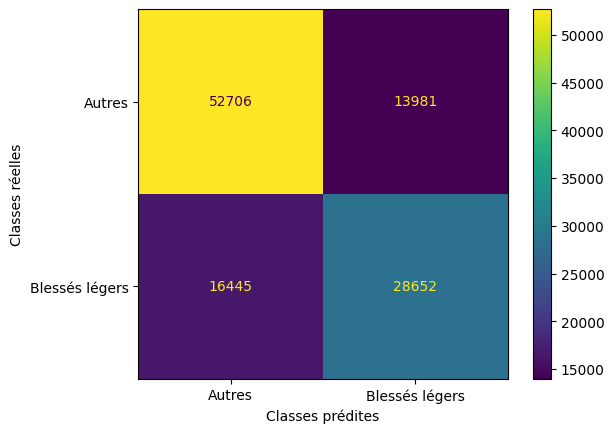

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y__test_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        rf_bl_legers_model,
        X_test_rf,
        y_test,
        display_labels=['Autres','Blessés légers']
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig('../../../data/img/'+ 'rf_binaire_bllegersvsautres_confusion_matrix' + '.png')

### Feature importance

In [123]:
importances_best_model = pd.DataFrame({'feature':X_train_rf.columns,'importance':np.round(best_model.feature_importances_,3)})
importances_best_model = importances_best_model.sort_values('importance',ascending=False).set_index('feature')
importances_best_model.head(38)

,importance
feature,
place_rec,0.090
lat,0.081
eq_ceinture,0.078
catv,0.074
long,0.070
obsm,0.066
age_usager,0.060
col,0.054
eq_casque,0.045


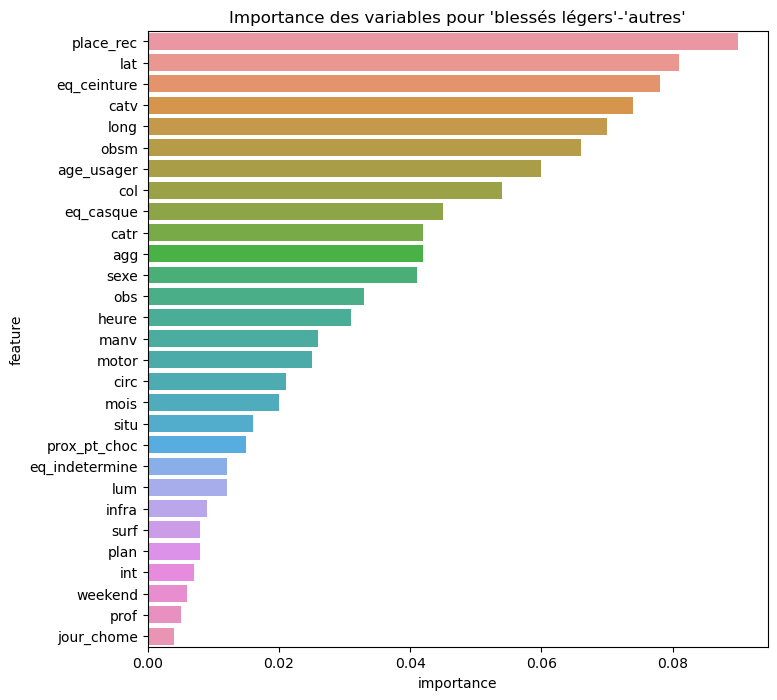

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 8))
sns.barplot(y = importances_best_model.index, x = importances_best_model['importance'])
plt.title("Importance des variables pour 'blessés légers'-'autres'")
plt.show()

### Interprétation avec SHAP

In [126]:
import shap

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_rf)

print('Expected Value:', explainer.expected_value)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Expected Value: [0.52585498 0.47414502]


In [127]:
print(shap_values.shape)
print(type(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

(111784, 29, 2)
<class 'numpy.ndarray'>
(29, 2)
(29, 2)


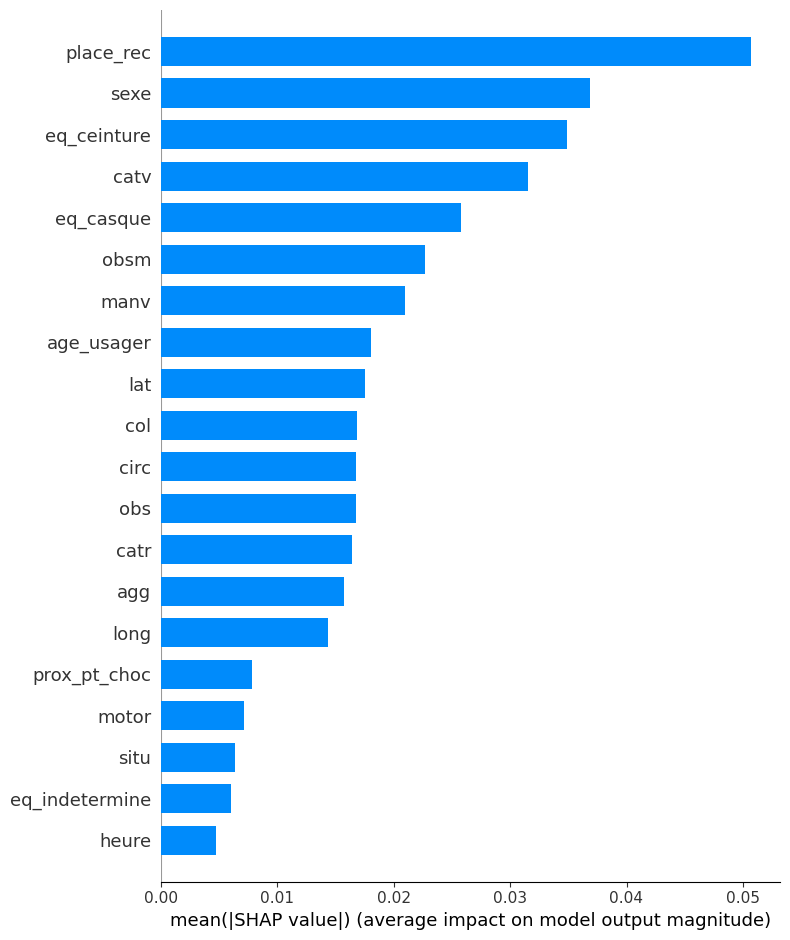

In [156]:
# Pour la classe 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, plot_type="bar")

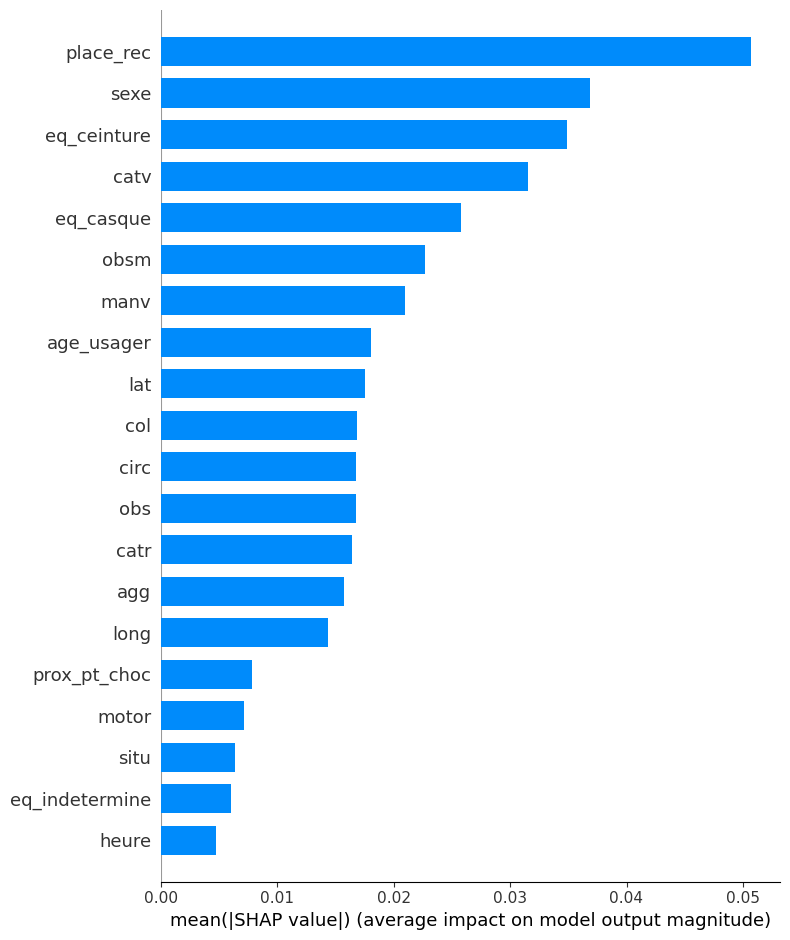

In [154]:
# Pour la classe 'blessés légers'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, plot_type="bar")

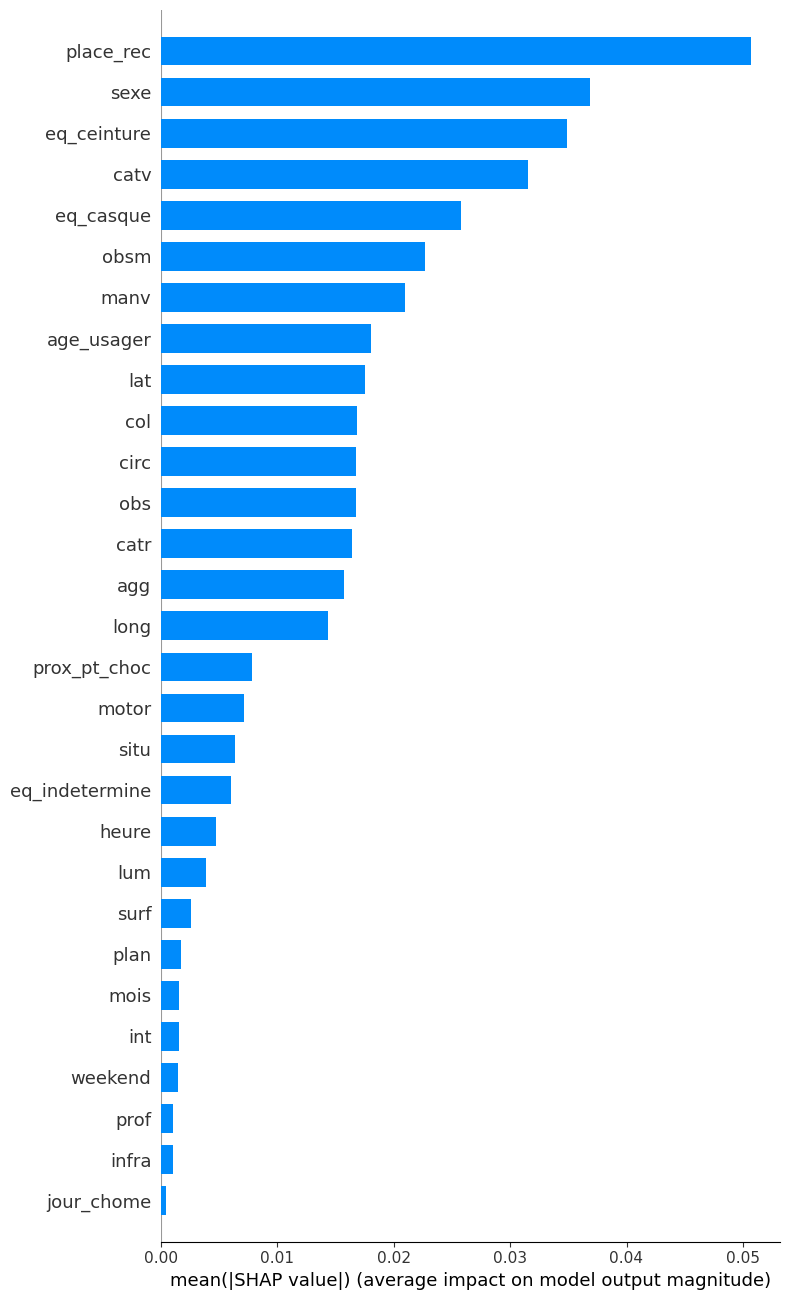

In [158]:
shap.summary_plot(shap_values[:, :, 0], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

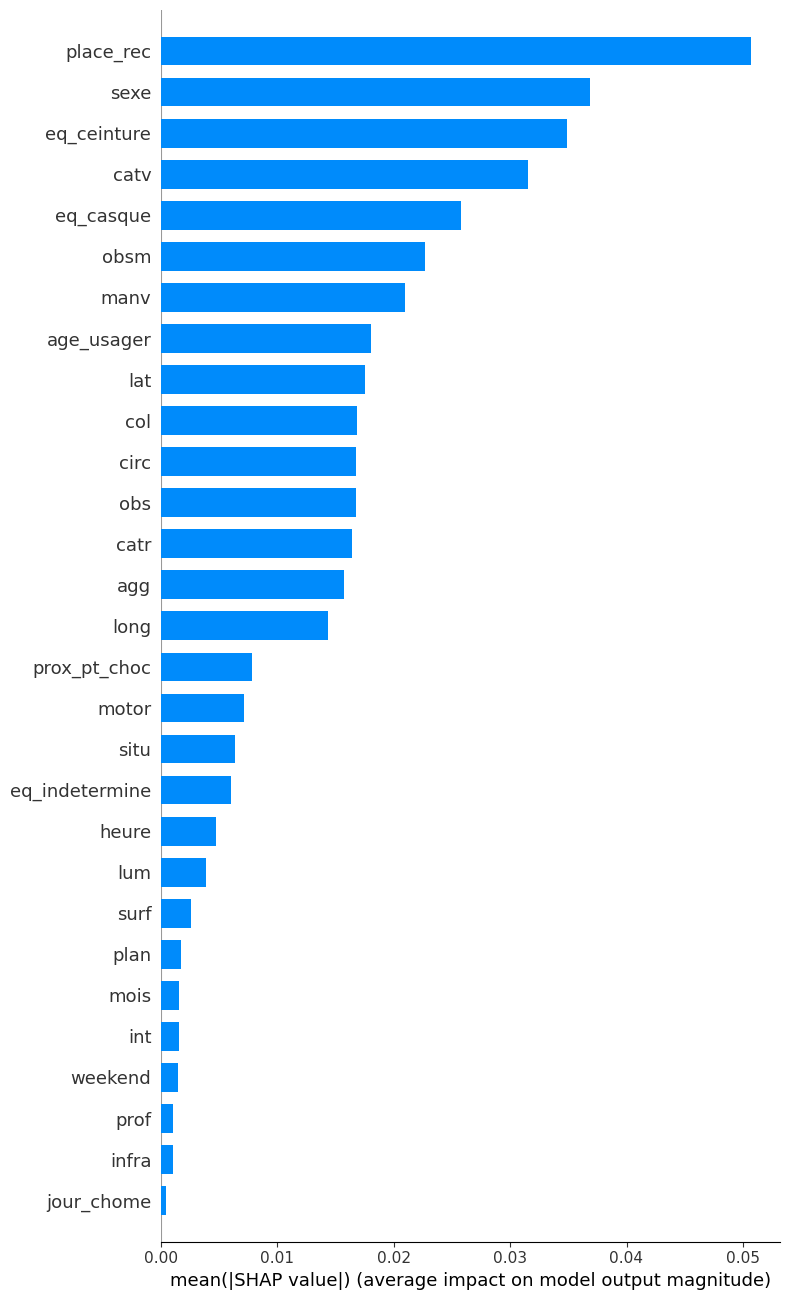

In [157]:
shap.summary_plot(shap_values[:, :, 1], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

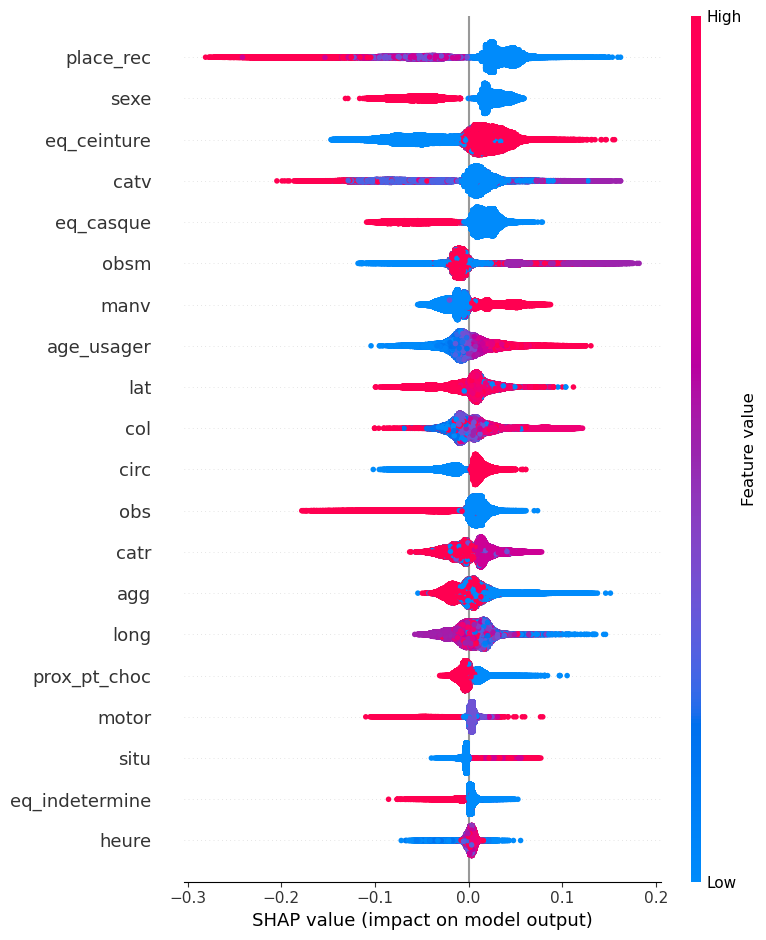

In [153]:
# Pour les 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf)

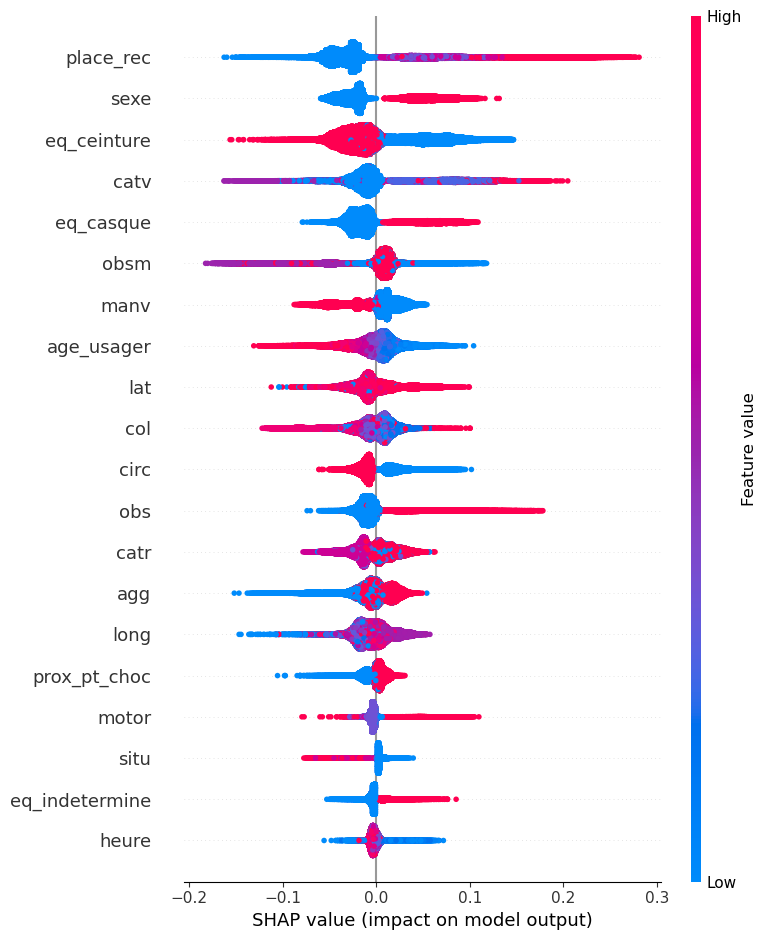

In [152]:
# Pour les 'blessés légers'
shap.summary_plot(shap_values[:, :, 1], X_test_rf)

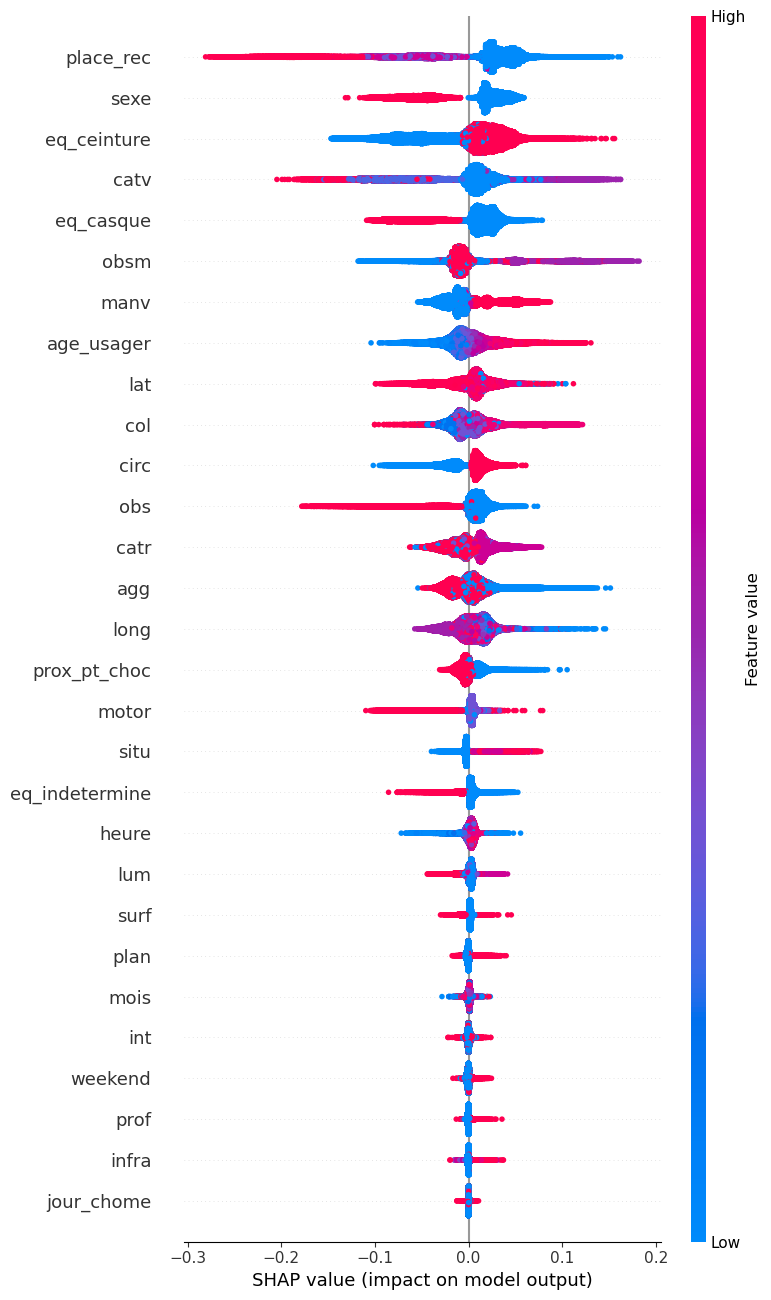

In [159]:
shap.summary_plot(shap_values[:, :, 0], X_test_rf, max_display = len(X_test_rf))

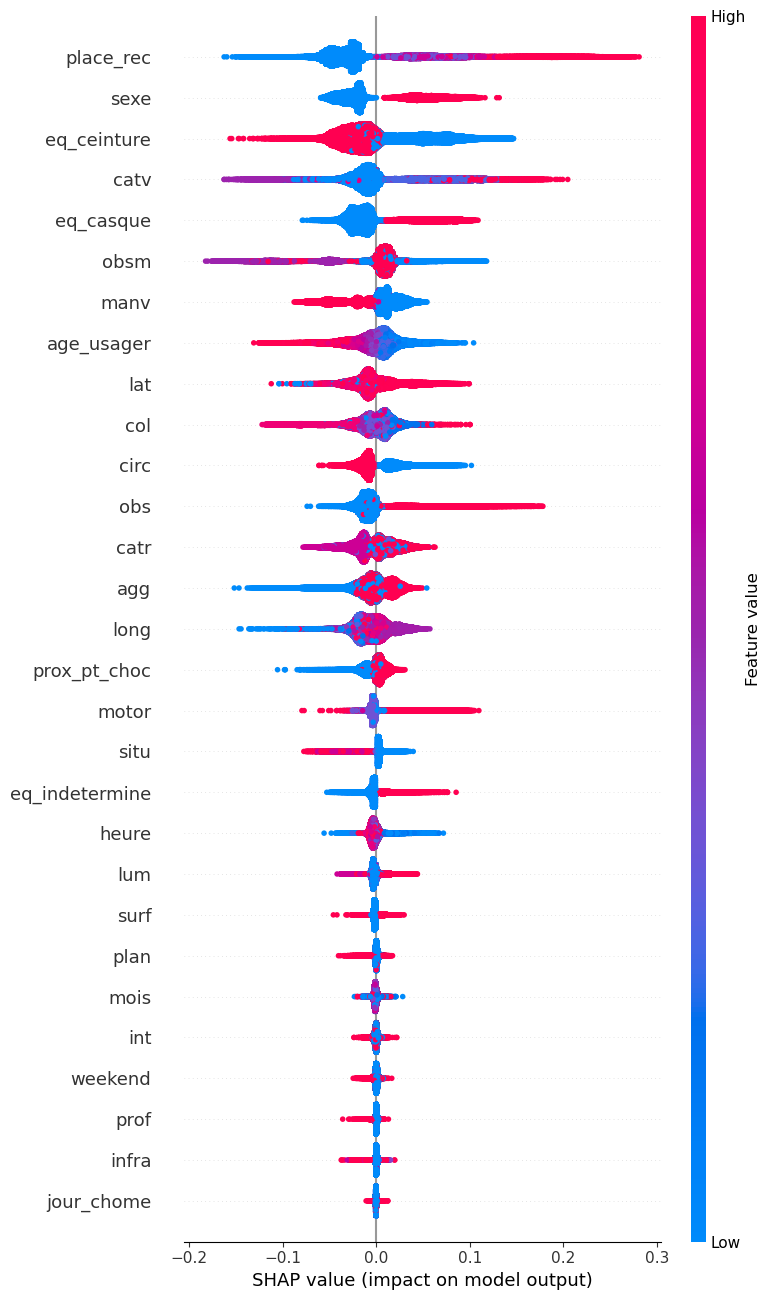

In [160]:
shap.summary_plot(shap_values[:, :, 1], X_test_rf, max_display = len(X_test_rf))

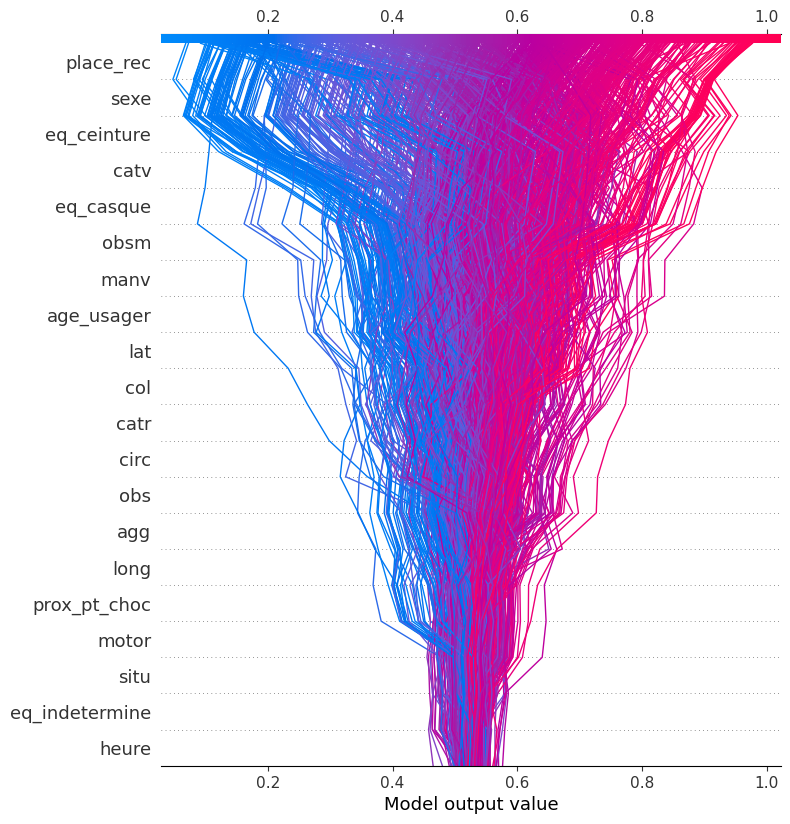

In [144]:
# détermination des variables qui contribuent au label '0'
shap.decision_plot(explainer.expected_value[0], shap_values[0:1000, :, 0], X_test_rf.columns)

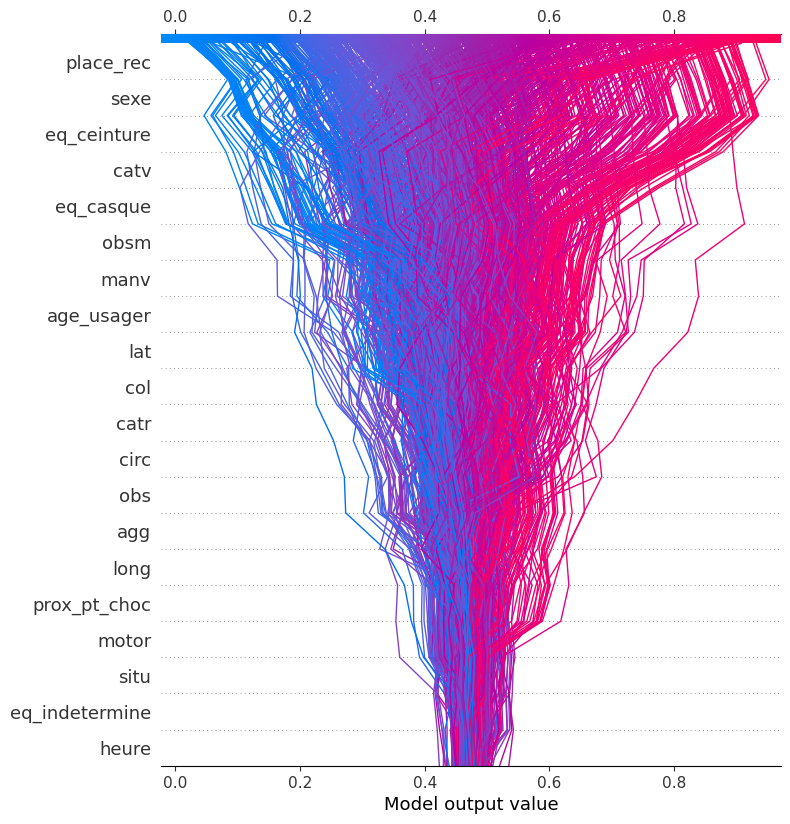

In [145]:
# détermination des variables qui contribuent au label '1'
shap.decision_plot(explainer.expected_value[1], shap_values[0:1000, :, 1], X_test_rf.columns)

# Améliorations du modèle avec monotonic_cts

In [13]:
weight = pd.DataFrame(X_test_rf.columns, columns = ['features'])
weight['weight'] = 0

In [22]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[i]= mono
        
        best_model = RandomForestClassifier(bootstrap = False, 
                                    class_weight = {0: 3, 1: 4}, 
                                    criterion = 'gini', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
        y_train_pred = best_model.predict(X_train_rf)
        y_test_pred = best_model.predict(X_test_rf)
        
        train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
        test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
        f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
        f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
        index_list.append(i)
        features_list.append(weight.loc[i]['features'])
        weight_list.append(mono)
        train_accuracy_list.append(train_accuray)
        test_accuracy_list.append(test_accuracy)
        f1_score_0_list.append(f1_scores[0])
        f1_score_1_list.append(f1_scores[1])
        f1_macro_list.append(f1_macros)

In [23]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 64.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
26,13,motor,-1,80.54,72.78,77.60,65.32,71.46
54,27,eq_casque,-1,80.47,72.74,77.58,65.25,71.41
17,8,eq_ceinture,1,80.24,72.75,77.60,65.20,71.40
42,21,prof,-1,80.15,72.68,77.46,65.34,71.40
34,17,weekend,-1,80.09,72.72,77.56,65.23,71.40
43,21,prof,1,80.31,72.79,77.71,65.07,71.39
35,17,weekend,1,80.15,72.77,77.68,65.07,71.38
52,26,plan,-1,79.97,72.64,77.40,65.36,71.38
57,28,eq_indetermine,1,80.01,72.81,77.76,65.01,71.38
8,4,mois,-1,79.97,72.70,77.54,65.20,71.37


In [24]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 13

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = -1
        if (i != j):
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = False, 
                                                class_weight = {0: 3, 1: 4}, 
                                                criterion = 'gini', 
                                                max_depth = 15, 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2, 
                                                n_estimators = 100, 
                                                n_jobs = -1, 
                                                random_state = 42,
                                                monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [25]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 64.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
35,18,jour_chome,1,80.36,72.79,77.64,65.25,71.45
52,27,eq_casque,-1,80.59,72.75,77.59,65.27,71.43
43,22,int,1,80.23,72.74,77.56,65.30,71.43
9,4,mois,1,80.06,72.77,77.64,65.21,71.42
26,14,infra,-1,80.14,72.69,77.47,65.35,71.41
40,21,prof,-1,80.20,72.69,77.46,65.36,71.41
34,18,jour_chome,-1,80.43,72.73,77.56,65.27,71.41
50,26,plan,-1,80.14,72.66,77.41,65.39,71.40
55,28,eq_indetermine,1,80.13,72.84,77.83,64.96,71.39
42,22,int,-1,80.15,72.74,77.60,65.16,71.38


On s'arrête ici pour les ajustement car le f1_macro diminue. On a ajusté la variables 'motor'

In [14]:
weight['weight'] = 0
weight["weight"].values[13] = -1

best_model = RandomForestClassifier(bootstrap = False, 
                                    class_weight = {0: 3, 1: 4}, 
                                    criterion = 'gini', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 80.54 %
Test acuracy :  72.78 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,52706,13981
1,16445,28652



Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.79      0.78     66687
           1       0.67      0.64      0.65     45097

    accuracy                           0.73    111784
   macro avg       0.72      0.71      0.71    111784
weighted avg       0.73      0.73      0.73    111784



In [15]:
joblib.dump(best_model, "../../../data/saved_models/RandomForest_2classes_blesseslegers_autres.joblib")

['../../../data/saved_models/RandomForest_2classes_blesseslegers_autres.joblib']

In [16]:
fich = conf['local_data_path'] + "/saved_models/RandomForest_2classes_blesseslegers_autres.joblib"
fich_zip = conf['local_data_path'] + "/saved_models/RandomForest_2classes_blesseslegers_autres.zip"
myZip = zipfile.ZipFile(fich_zip, 'w', zipfile.ZIP_DEFLATED)
myZip.write(fich)
myZip.close()